<a href="https://colab.research.google.com/github/sscs-ose/sscs-ose-chipathon.github.io/blob/main/template_notebook_to_follow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PMIC for lab-bench-on-chip

```
AC3E-UTFSM-Chile Team, February 2023
SPDX-License-Identifier: Apache-2.0
```


|Name|Email|Affiliation|IEEE Member|SSCS Member|
|:--:|:--:|:----------:|:----------:|:----------:|
|Aquiles Viza Vergara|aquiles.viza@sansano.usm.cl | Universidad Técnica Federico Santa María|No|No|
|Daniel Arevalos Ortiz|daniel.arevalos@sansano.usm.cl| Universidad Técnica Federico Santa María|Yes|Yes|
|Max Vega Campos|max.vega@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Vicente Ramirez|vicente.ramirez@usm.cl|Universidad Técnica Federico Santa María |No|No|
|Alfonso Cortés Neira|alfonso.cortes@sansano.usm.cl|Universidad técnica Federico Santa María|Yes|Yes|
|Andrés Martínez|andres.martinezf@sansano.usm.cl|Universidad técnica Federico Santa María|No|No|
|Joel Gak|jgak@ucu.edu.uy|Universidad Católica de Uruguay|Yes|Yes|
|Matías Miguez|mmiguez@ucu.edu.uy|Universidad Católica de Uruguay|Yes|Yes|
|Nicolás Calarco|ncalarco@ucu.edu.uy |Universidad Católica de Uruguay|Yes|Yes|
|Jorge Marín (Lead) <br />|jorge.marinn@usm.cl|AC3E|Yes|Yes|
|Christian Rojas|c.a.rojas@ieee.org|AC3E, Universidad Técnica Federico Santa María|Yes|No|
|Mustafa Labbad | mustafaellabad@gmail.com | Mabrains |No|No|
|Amro Tork (Advisor) |amro_tork@mabrains.com|Mabrains|No|No|

**_Abstract_** - Current advances in integration technologies allows to put an entire system on a single chip die. This level of integration has a lot of challenges, one of the most relevant is power integrity to ensure all the building blocks within the ASIC receive the required supply voltage/current levels with noise levels within their specifications. In this project, the main focus is on the power management unit for the Chipathon 2023 Lab-Bench On Chip. The aim is to analyze the potential of the DCDC-LDO on chip signal chain, using building blocks available in the SKY130 technology, and study, desing and implement from specification to GDS a system for two (or more) regulated supplies in the GlobalFoundries’ GF180MCU technology.

**_Key words_** - PMU; PMIC; Power Management; LDO; Buck Converter; Microelectronics.


## Tools and input files

### Install tools and dependencies

The cells below will install all the necessary tools to excecute this notebook. It is highly recommended to run this notebook in **Google Colab**, as it was tested in that environment.

In [1]:
##@title Install dependencies {display-mode: "form"}
##@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

#ngspice_version = 'latest' #@param {type:"string"}
#gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}

ngspice_version = 'latest'
gf180mcu_fd_pr_version = 'latest'

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
from pathlib import Path
import urllib.request

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt


!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     ngspice={ngspice_version} \
                     iverilog \
                     open_pdks.sky130a > \dev\null

ngspice_models_dir = Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)

  # Try with this
  # !wget -P {gf180_ngspice_url}/{m}
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/design.ngspice
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/sm141064.ngspice
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/sm141064_mim.ngspice
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/smbb000149.ngspice
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:

### Download input files
This code block will clone all the necessary input files.

In [2]:
path = {
  "project": Path("PMIC_lab-on-chip_power-management").resolve(),
}

# Repo download
###############
git_repo = "https://github.com/lild4d4/PMIC_lab-on-chip_power-management.git"

if not path["project"].exists():
  !git clone {git_repo}
else:
  print("Erasing project")
  !rm -rf {path["project"]}
  !git clone {git_repo}

Erasing project
Cloning into 'PMIC_lab-on-chip_power-management'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 69 (delta 19), reused 58 (delta 8), pack-reused 0
Unpacking objects: 100% (69/69), 666.19 KiB | 7.09 MiB/s, done.


### Tools configuration

In [3]:
%%writefile .spiceinit
set ngbehavior=hs
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
*set ngbehavior=hsa
* "nomodcheck" speeds up loading time
*set ng_nomodcheck

Overwriting .spiceinit


### References to important files and directories

In [4]:
# Path variables
################

path["sky130_base"]       = Path("conda-env").resolve()
path["sky130_ngspice"]    = path["sky130_base"] / "share" / "pdk" / "sky130A" / "libs.tech" / "ngspice"
path["sky130_xschem"]     = path["sky130_base"] / "share" / "pdk" / "sky130A" / "libs.tech" / "xschem"

path["project_ldo"]       = path["project"] / "LDO"
path["project_ldo_spice"] = path["project"] / "LDO" / "ldo_v2.spice"
path["project_ldo-spice"] = path["project"] / "LDO" / "ldo_v2.spice"

path["project_dcdc"]      = path["project"] / "DC-DC Converter"
path["project_dcdc-core_testbench_wfilter_vfinal"] = path["project_dcdc"] / "core_testbench_wfilter_vfinal.spice"

# path["Figures"] = path["project"] / "Figures/dc-dc_converter_schm"

for resource in path.values():
  if not resource.exists():
    print(f"file {resource} doesn't exists")

# Specific file verification
##############################

if not (path["sky130_ngspice"] / "sky130.lib.spice").exists():
  print("sky130 spice doesn't exist!")

## I. Introduction

Power management is an unavoidable concern in aplication integrated cricuits (ASIC) design projects. The importance of power considerations gets even more critical when we consider future energy autonomous systems such as the one depicted in Figure 1, which represents a sensor node with energy harvesting capabilities and analog, mixed signal and digital on-chip blocks. The most challenging blocks downstream towards the functional building blocks are the DCDC and the LDO(s) and their configurations, highlighted in Figure 1. In previous works, this problem has been considered by eliminating the LDO and replacing it by an active filter [4] or by considering different DCDC-LDO on-chip or off-chip configurations, depending on the requirements [5]. In this project, we will focus on a full on-chip solution, and thus we will analyze the efficiency, area/speed performance and interference among power channels for an implementation using the GF180 opensource CMOS technology.

In the context of the 2023 SSCS "PICO" Chipathon competition, and inspired by the problem described above, the objective of this project is to design a power management module for a lab-bench-on-chip. The proposed PMIC includes a DC-DC converter and Low-Droput regualator modules. Both the converter and the LDO will be re-designed based on existing open-source projects that target Skywater 130nm technology:
* **3-Level Flying Capacitor Converter**: https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI23/accepted_notebooks/3LFCC/ and https://github.com/JorgeMarinN/3LFCC_AC3E_Tapeout
* **LDO**: https://github.com/mabrains/caravel_user_project_ldo

The designs from these reference projects will be modified to target Global Foundries 180nm, while adjusting their specifications so that the entire PMIC system can supply the voltage/current levels required by the other blocks in the lab-bench-on-chip architecture.

As we design the proposed PMIC, we aim to add value to the project by addressing the following challenges:
* **Automated layout generation**: previous work of the team on power transistors layout will be improved, and the automated generation of the LDO layout will also be explored. 
* **Technology node portability**: while changing the target node of existing proyects with focus on automatic layout generation, a generalized aproach can be explored to facilitate technology portability.

Further, the automated specs-to-GDS flow for the entire DCDC-LDO system can be achieved. The final goal is to generate layout realizations from a list of specs such as supply voltage/current levels and maximum ripple.

<div align="center">

<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/green-electronics-microsystem.png" width=900/>

Figure 1: Green electronics sensor node motivation example - the project target blocks are enclosed in green shapes
</div>

<div align="center">

<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/System_diagram.png" width=700/>

Figure 2: Design target in (a) including a cascade of a DCDC and severlal LDO blocks, and (b) a proposed load of interest consisting of a SAR ADC including digital and analog building blocks.
</div>

## II. Implementation Details of your Idea

In the following subsections, it will be decribed the most relevant building blocks needed to implement the power management core used to generate the on-chip supplies for the lab-bench-on-chip building blocks, including the selected topologies (which may vary after finishing the preliminary study), the main design parameters and some initial simulations.

## 3-level flying capacitor DCDC converter stage

In this subsection, the 3-level flying capacitor converter (3LFCC) architecture to be used in the project is described. The topology shows good simulated efficiency and ripple performance on the previous implementation using the SKY130 technology [1]. Furthermore, an automated generator flow which provides a GDS file from high-level specs such as the output current and the total chip area has been implemented in [2]. Therefore, this building block can be easily generated after adapting the automated flow to the GF180 PDK technology, and is a good initial choice for our design.

<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/dc-dc_converter_schm.png" width=600/>

Figure 3: DC-DC Converter Schem
</div>

### Subcircuit-level design:


1.   Power Stage:

This stage consists of the four power transistors (two PMOS and two NMOS devies) which switch the flying capacitor electric position to generate the needed output states for the DCDC module. They constitute the most area consuming part of the system, since their ON resistance (as low as posible needed) is inversely proportional to their area, and thus static efficiency directly depends on their sizing. Therefore, they need to be optimized for the required power consumption. The main challenge regarding this block is to translate the know-how obtained for the SKY130 technology to the GF180 technology, which has not been verified in post-silicon measurements.

<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/dc_power-stage.png" width=200/>

Figure 4: Power Stage Schem
</div>

2. Gate Drivers

The implemented gate drivers [3] need to charge and discharge the power MOS gates in a minimum time, to perform according to the frequency specifications of the system. The transistion time is relevant to define the dead time needed in the digital switching input signals, which are provided off-chip in our implementation.

The main parameter is the gate driver output stage strength, which defines how much current can be driven or sunk by the circuit. This parameter needs to be included in the automated generator [2], specifically for the GF180 technology.

3. Flying Capacitor

In the proposed implementation, opposite to the work in [1], the flying capacitors are placed off chip, to optimize chip area and thus silicon costs. The drawback are the parasitics introduced by the bonding wires, the package, the PCB traces and the discrete capacitance components. These factors need to be analyzed in the context of the GF180 PDK.


The DCDC block initial specifications are provided in the Table I. This specifications will be adapted along the project development to match the requirements of the lab-bench-on-chip power consumption profiles, which are a priori unknown.

|Parameter |Value |Units|
|:--:|:--:|:----------:|
|Vin|5|V|
|Vout|3.3/1.8|V|
|Iout_max | > 300|mA|
|Switching Frequency |  1|MHz|
|Rated Power | > 0.5|W|
|Target Max. Efficiency | > 90 |%|
|Temperature Operation | -40 to +853|°C|\

Table I: DCDC Specs

###3LFCC preliminary simulations

In the next code block, the 3LFCC transient simulation is presented for 2 cores and a 300mA output current pero core, including an off-chip LC filter, onverting from 5V to ~3.3V. The plot shows the output waveform with a ripple around 100mV peak-to-peak.


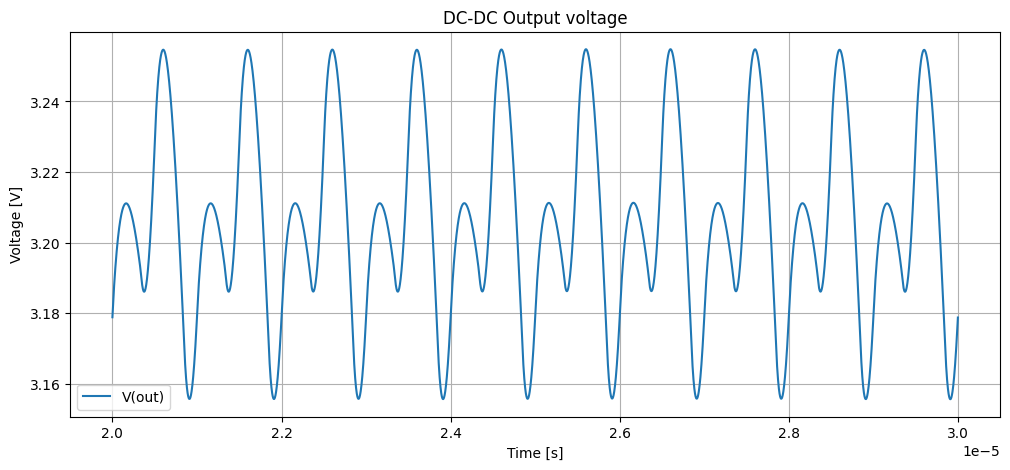

In [5]:
# Simulation Setup
##################
!rm -rf dc-dc.txt
# Remove "DC-DC Converter" and put "DC-DC_Converter" or something like that
!ngspice -b "{path['project_dcdc-core_testbench_wfilter_vfinal']}" &> /dev/null

# Simulation analysis
#####################
df = pd.read_csv("dc-dc.txt", delim_whitespace=True)
df.columns = ["Time [s]", "V(out)"]

fig, ax = plt.subplots()
fig.set_size_inches(12, 5, forward=True)

ax.set_title("DC-DC Output voltage")
ax.set_ylabel("Voltage [V]")
df.plot(x="Time [s]", y="V(out)", grid=True, ax=ax)

fig.show()

## Regulation stage

For the subsystem corresponding to the LDO, a design in SKY130 already exists, which is based on the work previously developed by Mabrains (who are part of the advisors of this proposal) -[Mabrains/caravel_user_project_ldo: Completed LDO Design for Skywaters 130nm (github.com)](https://github.com/mabrains/caravel_user_project_ldo)-. 

<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/ldo_schem.png" width=600/>

Figure 5: LDO Schem
</div>

### Subcircuit-level design:



1.   Error Amplifier

The error amplifier in an LDO performs the function of comparing the output voltage of the LDO with a reference voltage and generating an error signal that is used to adjust the output voltage.
As a result, the LDO can maintain a stable output voltage even when the input voltage or load current varies. The design of the error amplifier is critical to the performance of the LDO


<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/error-amp_schem.png" width=600/>

Figure 6: Error Amp Schem
</div>

2.   Bandgap

Bandgap subcircuit is  used to generate a stable and accurate internal voltage reference. This technique uses the characteristics of semiconductor material to generate a fixed reference voltage. This reference voltage is used to control the feedback circuit of the LDO and maintain a constant output voltage as the load or input voltage changes.


<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/bandgap_schem.png" width=1000/>

Figure 7: Bandgap Schem
</div>

The specs can be seen in the Table II (also taken from the Mabrains repository):

| Specification             | TT                           |
| ------------------------- | ---------------------------- |
| Temperature Coefficient   | 49.4 ppm/°C                  |
| Dropout Voltage @IL=0.1mA | 0.211mV                      |
| Dropout Voltage @IL=10mA  | 85.6mV @IL=10mA              |
| Dropout Voltage @IL=100mA | 168.45mV @IL=100mA           |
| Line Regulation           | 0.0325 mv/v                  |
| Load Regulation           | 0.06mV IL=0.1mA till IL=10mA |
| PSRR @ 100Hz              | 88.1dB                       |
| PSRR @ 100kHz             | 44.7dB                       |
| Load range                | 50uA -> 100mA                |
| Phase Margin              | 50.1°                        |
| Quiescent Current         | 130uA                        |
| Startup time              |     7uS|

Table II: LDO Specs


The aim is to:
1. Convert this design to GF180 and check if we can achieve similar performance
2. Scale the current drive capabilities to match our requirements according to the case study load, e.g. one for analog loads and one for digital loads


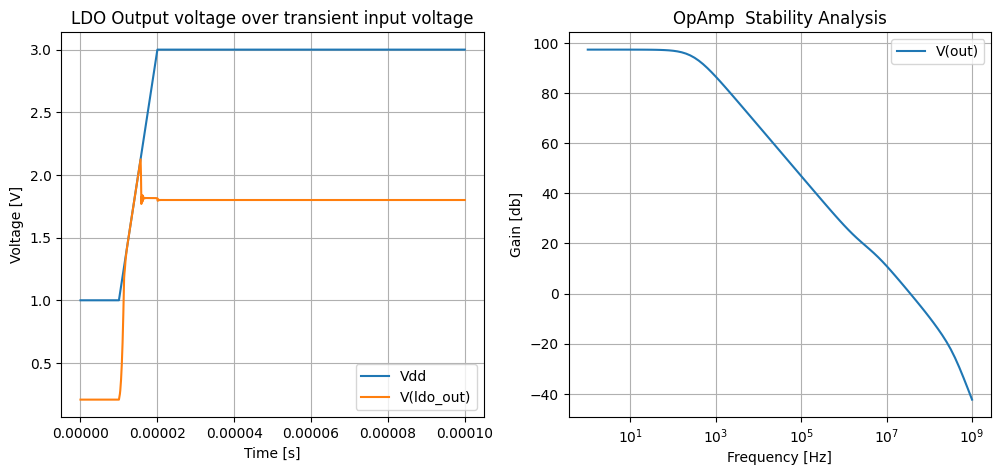

In [6]:
# Simulation Setup
##################
!rm -rf output.txt
!rm -rf supply_sweep.txt
!rm -rf PSRR_Analysis.txt
!rm -rf Stability_Analysis.txt
!rm -rf Transient.txt

!ngspice -b {path["project_ldo-spice"]} &> /dev/null

# Simulation Analysis
#####################
df1 = pd.read_csv("Stability_Analysis.txt", delim_whitespace=True)
df1.columns = ["Frequency [Hz]", "V(out)"]
df2 = pd.read_csv("Transient.txt", delim_whitespace=True)
df2.columns = ["Time [s]", "Vdd", "V(ldo_out)"]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5, forward=True)

ax[0].set_title("LDO Output voltage over transient input voltage")
ax[0].set_ylabel("Voltage [V]")
df2.plot(x="Time [s]", y="Vdd", grid=True, ax=ax[0])
df2.plot(x="Time [s]", y="V(ldo_out)", grid=True, ax=ax[0])

ax[1].set_title("OpAmp  Stability Analysis")
ax[1].set_ylabel("Gain [db]")
ax[1].set_xscale('log')
df1.plot(x="Frequency [Hz]", y="V(out)", grid=True, ax=ax[1])
fig.show()

## III. Summary of the idea

The main objective is to implement a full DCDC converted + LDO power management system from specifications to GDS/Tapeout, exploring the capabilities of the GF180 technology to perform these kind pf functions, as demonstrated in our previous work. The architecture and the initial building blocks will be based on the description above, but further reserch on the specific aspects of this technology may motivate other topology choices.

A secondary objective of the project is to focus on analog mixed-signal IC design automation starting on early design stages. An initial target is to extend our previous work using scripted layout generators for the building blocks of the system, focused until now on the 3LFCC DCDC, but now including the LDO design. Later, aspects such as technology portability (e.g. between the SKY130 and the GF180 technologies) can be considered, if time allows.

Further more, the consolidation of colaborative work of the envolbed reserch groups will be a miles stone for this project.

### System specifications

[REVISAR ESTO!!!!!]


* Input voltage of 5V
* Two (or more) regulated DC outputs with stantard levels: 1.8V and 3.3V
* Output ripple 
* Target max. effiency

|  Parameter  |   Value   | Units |
|-------------|-----------|-------|
|     Vin     |     5     |   V   |
|  Vout$_i$   |  1.8, 3.3 |   V   |
| Switching frequency | 1-10 | MHz |


## IV. Planification and Tasks

Planning and breakdown of tasks are usually helpful for a successful project. Good Luck!

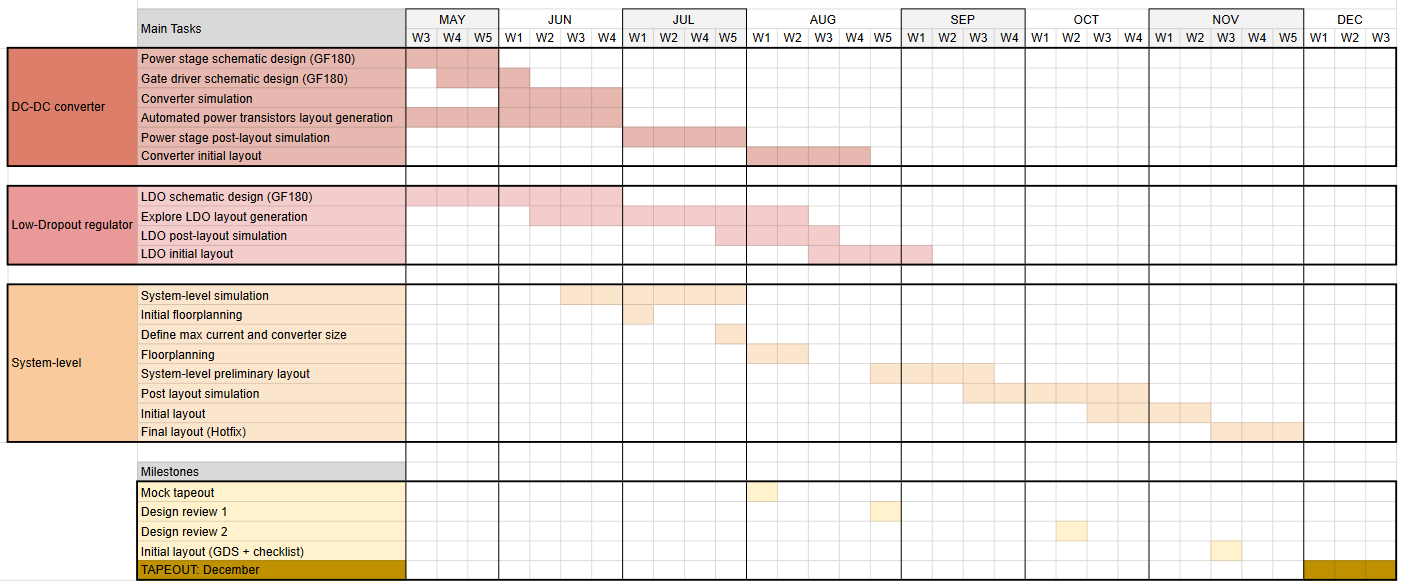

## V. References


[1] J. Marin et al., "Integrated Three-Level Flying Capacitor DC-DC Buck Converter for CubeSat Applications," 2023 Argentine Conference on Electronics (CAE), Cordoba, Argentina, 2023, pp. 90-95, doi: 10.1109/CAE56623.2023.10087013.

[2] https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI23/accepted_notebooks/3LFCC/3LFCC_v2p0.ipynb

[3] Gak, J., Miguez, M., & Arnaud, A. (2021). CMOS Level Shifters from 0 to 18 V Output. Analog Integr. Circuits Signal Process., 107(3), 617–628.

[4] S. Kose, S. Tam, S. Pinzon, B. McDermott and E. G. Friedman, "Active Filter-Based Hybrid On-Chip DC–DC Converter for Point-of-Load Voltage Regulation," in IEEE Transactions on Very Large Scale Integration (VLSI) Systems, vol. 21, no. 4, pp. 680-691, April 2013, doi: 10.1109/TVLSI.2012.2190539.

[5] I. Vaisband and E. G. Friedman, "Heterogeneous Methodology for Energy Efficient Distribution of On-Chip Power Supplies," in IEEE Transactions on Power Electronics, vol. 28, no. 9, pp. 4267-4280, Sept. 2013, doi: 10.1109/TPEL.2012.2230408.
